In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.inp = nn.Linear(4, 512)
        self.hid1 = nn.Linear(512, 1024)
        self.hid2 = nn.Linear(1024, 512)
        self.hid3 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.inp(x))
        x = F.relu(self.hid1(x))
        x = F.relu(self.hid2(x))
        x = F.relu(self.hid3(x))
        x = self.out(x)
        return x

In [0]:
def checkfornan(df):
    ncall, nemail, nlang, ncount, nweb, npage, npc, npurchase = [{'No_of_NaN': 0} for _ in range(8)]
    for e in df.values:
        if np.isnan(e[1]):
            ncall['No_of_NaN'] += 1
        if np.isnan(e[2]):
            nemail['No_of_NaN'] += 1
        if e[6] == 'null':
            nlang['No_of_NaN'] += 1
        if e[7] == 'null':
            ncount['No_of_NaN'] += 1
        if np.isnan(e[8]):
            nweb['No_of_NaN'] += 1
        if np.isnan(e[9]):
            npage['No_of_NaN'] += 1
        if e[10] == 'null':
            npc['No_of_NaN'] += 1
        if e[11] == 'null':
            npurchase['No_of_NaN'] += 1
    dt = {'NumCalls': ncall, 'NumEmails': nemail, 'Languages': nlang, 'Country': ncount, 'WebVisits': nweb,
          'PageVisits': npage, 'PriorClient': npc, 'MadeAPurchase': npurchase}
    dt = pd.DataFrame.from_dict(dt)
    return dt

In [0]:
def preprocess(df):
    cvw = {}
    cvl = {}
    cve = {}
    for e in set(df['Country'].values):
        cvw[e] = [0, 0]
        cvl[e] = []
        cve[e] = {'No_of_Calls': 0, 'No_of_Emails': 0, 'No_of_Languages_Used': 0, 'No_of_WebVisits': 0,
                  'No_of_Prior_Clients': 0, 'No_of_Purchases': 0}
    for e, l in zip(df['Country'].values, df['Language'].values):
        cvl[e].append(l)
        cvl[e] = list(set(cvl[e]))
        cve[e]['No_of_Languages_Used'] = len(cvl[e])

    for n, e, c, w, pc, p in zip(df['NumCalls'].values, df['NumEmails'].values, df['Country'].values,
                                 df['WebVisits'].values, df['PriorClient'].values, df['MadeAPurchase'].values):
        if np.isnan(w):
            cvw[c][1] += 1
        else:
            cvw[c][0] += w
            cve[c]['No_of_Calls'] += n
            cve[c]['No_of_Emails'] += e
            cve[c]['No_of_WebVisits'] += w
            if pc == 'Yes':
                cve[c]['No_of_Prior_Clients'] += 1
            if p == 'Yes':
                cve[c]['No_of_Purchases'] += 1

    return cvw, cvl, cve
    

def eda(df):
    CvW, CvL, CvE = preprocess(df)
    CvE = pd.DataFrame.from_dict(CvE)
    print(CvE)

    x = CvW.keys()
    y = [x[0] for x in CvW.values()]
    z = [x[1] for x in CvW.values()]

    width = 0.8
    plt.figure(figsize=(20, 8))
    plt.bar(x, y, width, color='b', align='center', label='No. of visits')
    plt.bar(x, z, width, color='r', align='center', label='Cannot Distinguish')
    plt.xlabel('Consumers from Countries')
    plt.ylabel('Web Visits')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(20, 5))
    x = CvL.keys()
    y = [len(e) for e in CvL.values()]
    plt.bar(x, y, width, color='r', align='center')
    for idx, val in zip(x, y):
        plt.text(idx, val, str(val))
    plt.xlabel('Consumers from Countries')
    plt.ylabel('No. of Languages Used')
    plt.xticks(rotation=45)
    plt.show()

In [0]:
def data_preprocess(df):
    l = []
    for n, e, w, pc, p in zip(df['NumCalls'].values, df['NumEmails'].values, df['WebVisits'].values,
                              df['PriorClient'].values, df['MadeAPurchase'].values):
        if not np.isnan(w):
            if pc == 'Yes':
                if p == 'Yes':
                    l.append([n, e, w, 1, 1])
                else:
                    l.append([n, e, w, 1, 0])
            else:
                if p == 'Yes':
                    l.append([n, e, w, 0, 1])
                else:
                    l.append([n, e, w, 0, 0])
    return l

In [0]:
def training(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, X_test, Y_test, epochs):
    train_loss, val_loss = [], []
    for e in range(epochs):
        model.train()
        x, y = X_train.float(), Y_train.long()
        optimizer.zero_grad()
        output = model.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        t_loss = loss.item()*x.size(0) / len(x)
        train_loss.append(t_loss)

        model.eval()
        x, y = X_val.float(), Y_val.long()
        output = model.forward(x)
        loss = criterion(output, y)
        v_loss = loss.item()*x.size(0) / len(x)
        val_loss.append(v_loss)

        print(f"Epoch: {e+1}  |  Training Loss: {train_loss[-1]}  |  Validation Loss: {val_loss[-1]}")
        if (e+1)%10 == 0:
            testing(model, X_test, Y_test)
        """try:
            if val_loss[-1] >= val_loss[-2]:
                break
        except:
            pass"""

    plt.plot(range(1, len(train_loss)+1), train_loss, 'b-', label='Training Loss')
    plt.plot(range(1, len(val_loss)+1), val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()


def testing(model, X_test, Y_test):
    model.eval()
    x, y = X_test.float(), Y_test.long()
    output = model.forward(x)
    _, pred = torch.max(output, dim=1)
    correct = pred.eq(y.view_as(pred)).sum()
    print(f"Test Accuracy: {100. * correct / len(x):.2f}%")

In [0]:
def main():
    pd.set_option('display.max_rows', 6, 'display.max_columns', 28)
    df = pd.read_csv('/content/drive/My Drive/Customers2.csv')
    print(checkfornan(df))
    print()
    eda(df)
    data = np.array(data_preprocess(df))
    #np.random.shuffle(data)

    train, val, test = np.split(data, [int(0.6*len(data)), int(0.8*len(data))])

    X_train, Y_train = torch.from_numpy(train[:, :-1]), torch.from_numpy(train[:, -1])
    X_val, Y_val = torch.from_numpy(val[:, :-1]), torch.from_numpy(val[:, -1])
    X_test, Y_test = torch.from_numpy(test[:, :-1]), torch.from_numpy(test[:, -1])

    model = Network()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    training(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, X_test, Y_test, epochs=30)

           NumCalls  NumEmails  Languages  Country  WebVisits  PageVisits  \
No_of_NaN         0          0          0        0         14          14   

           PriorClient  MadeAPurchase  
No_of_NaN            0              0  

                      Brazil  Singapore  Norway  Colombia  Serbia  India  \
No_of_Calls            105.0       65.0     0.0      68.0    27.0  144.0   
No_of_Emails            39.0      123.0     0.0      87.0     0.0   45.0   
No_of_Languages_Used     3.0        1.0     1.0       2.0     1.0    1.0   
No_of_WebVisits         46.0       41.0     0.0      78.0     1.0  130.0   
No_of_Prior_Clients     15.0        9.0     0.0      20.0     3.0    6.0   
No_of_Purchases         19.0        9.0     3.0      16.0     3.0   12.0   

                      Netherlands  Spain  Portugal  Argentina  Belgium  \
No_of_Calls                  48.0  341.0      64.0       27.0      0.0   
No_of_Emails                  6.0   27.0       0.0        6.0     12.0   
No_of_Lan

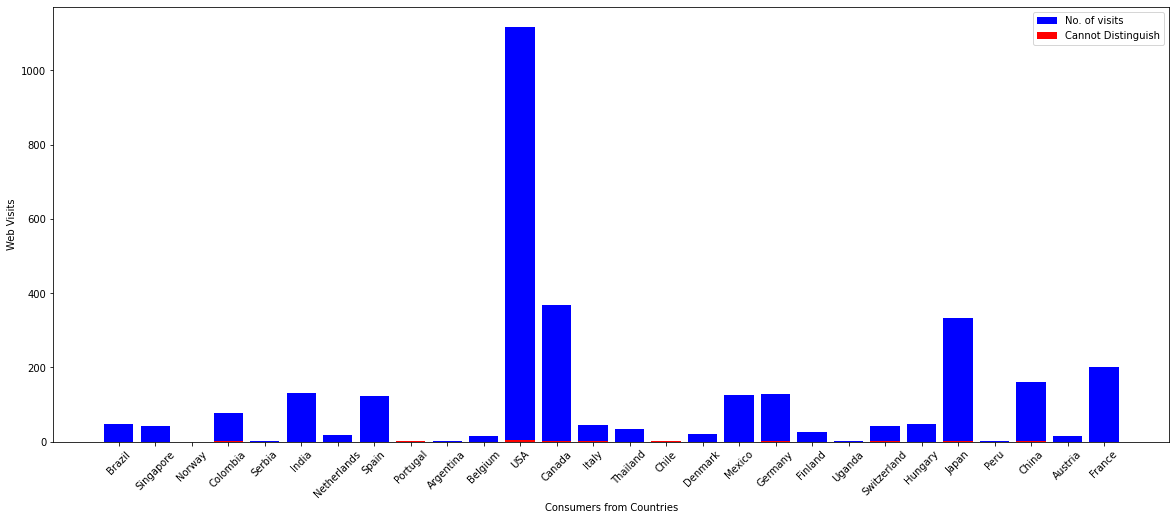

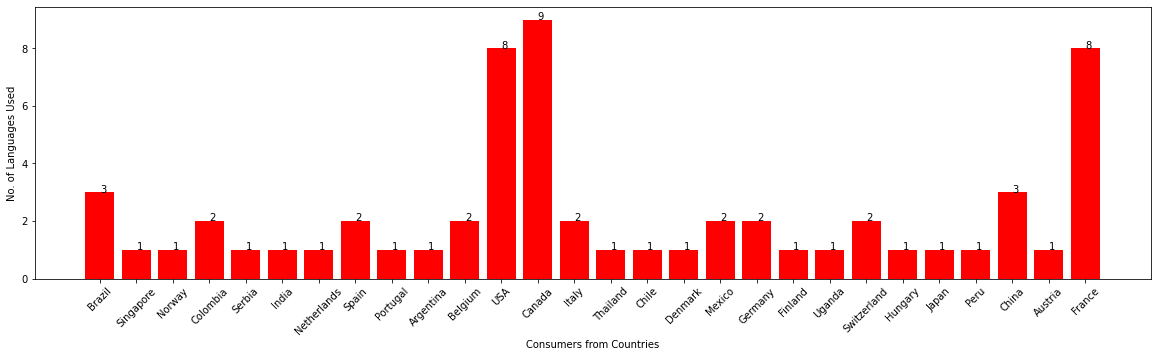

Epoch: 1  |  Training Loss: 0.6982073187828064  |  Validation Loss: 30.08812141418457
Epoch: 2  |  Training Loss: 68.06995391845703  |  Validation Loss: 4.359204292297363
Epoch: 3  |  Training Loss: 4.199170112609863  |  Validation Loss: 0.6347991228103638
Epoch: 4  |  Training Loss: 1.254932165145874  |  Validation Loss: 2.5997836589813232
Epoch: 5  |  Training Loss: 3.219007968902588  |  Validation Loss: 0.5993096232414246
Epoch: 6  |  Training Loss: 0.9415319561958313  |  Validation Loss: 0.6018424034118652
Epoch: 7  |  Training Loss: 0.7644898295402527  |  Validation Loss: 1.0731550455093384
Epoch: 8  |  Training Loss: 1.1809535026550293  |  Validation Loss: 0.6886962056159973
Epoch: 9  |  Training Loss: 0.6917016506195068  |  Validation Loss: 0.5851051807403564
Epoch: 10  |  Training Loss: 0.8382555246353149  |  Validation Loss: 0.5891042947769165
Test Accuracy: 68.92%
Epoch: 11  |  Training Loss: 0.7568343281745911  |  Validation Loss: 0.5942549705505371
Epoch: 12  |  Training Lo

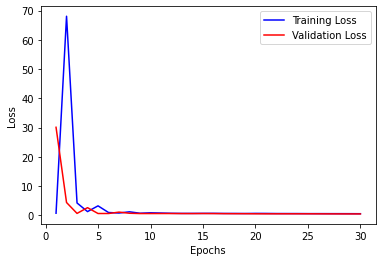

In [27]:
if __name__ == '__main__':
    main()